In [1]:
#%%=========================================================
# Intialize
# Had to put __future__ before other imports
from __future__ import division, print_function
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
from cStringIO import StringIO
import pickle

# The following commands are for use in the notebook environment
# Comment them out if this code is to be run in a python or ipython shell
%matplotlib inline
%config InlineBackend.figure_format = "retina"



//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#%%=========================================================
# This function downloads and caches a dataset from the exoplanet archive
# into a pandas frame
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df
    


In [3]:
periodInsolationSwitch = 'P' #raw_input("Period or Insolation: P or I? -- ")


In [4]:
catalogSwitch = '1' # raw_input("Catalog 9.1 or 9.2: 1 or 2? -- ")

In [5]:
stellarTypeSwitch = raw_input("Stellar type: GK, A, F, G, K, or M? -- ")

Stellar type: GK, A, F, G, K, or M? -- G


In [6]:
#%%=========================================================
# Get the stellar catalog and make selection cuts   
import numpy as np

# Choose desired stellar catalog
if(catalogSwitch == "1"):
    #!!!!! Q1-Q16 (9.1 pipeline)
    stlr = get_catalog("q1_q16_stellar")
elif(catalogSwitch == "2"):
    #!!!!! Q1-Q17 DR 24 (9.2 pipeline)
    stlr = get_catalog("q1_q17_dr24_stellar")


# Select stellar type
if(stellarTypeSwitch == 'A'):
    # !!!!! Select A dwarfs.
    m = (7300 <= stlr.teff) & (stlr.teff <= 10000)

elif(stellarTypeSwitch == 'F'):
    # !!!!! Select F dwarfs.
    m = (6000 <= stlr.teff) & (stlr.teff <= 7300)

elif(stellarTypeSwitch == 'G'):
    # !!!!! Select G dwarfs.
    m = (5300 <= stlr.teff) & (stlr.teff <= 6000)

elif(stellarTypeSwitch == 'K'):
    # !!!!! Select K dwarfs.
    m = (3900 <= stlr.teff) & (stlr.teff <= 5300)

elif(stellarTypeSwitch == 'M'):
    # !!!!! Select M dwarfs.
    m = (2400 <= stlr.teff) & (stlr.teff <= 3900)

elif(stellarTypeSwitch == 'GK'):
    # !!!!! Select GK dwarfs used i DFM original notebook.
    m = (4200 <= stlr.teff) & (stlr.teff <= 6100)


# stellar radius cut
# m &= stlr.radius <= 1.15

# logg cut
m &= stlr.logg > 4.0

# Only include stars with sufficient data coverage:

# Minimum dataspan of 2 years
m &= stlr.dataspan > 365.25*2.

# Minimum dutycycle of 1/2
#m &= stlr.dutycycle > 0.50
#### 0.6 in DFM original notebook:
m &= stlr.dutycycle > 0.60


# Minimum data coverage of 2 years
# comment out to compare to DFM origina notebook
#m &= stlr.dutycycle*stlr.dataspan > 365.25*2.

# maximum rms cdpp at 7.5 hour pulse (uncomment to compare to DFM original notebook)
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

# put selected data into pandas data frame
base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))


Selected 59792 targets after cuts


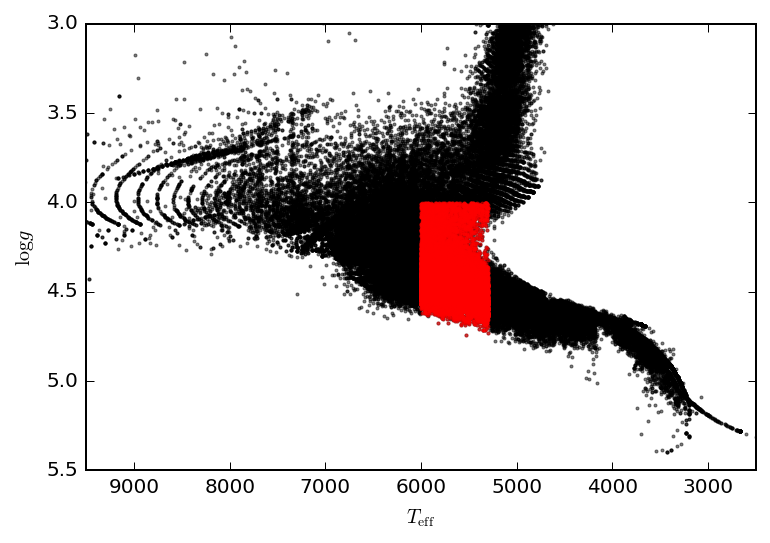

In [7]:
#%%=========================================================
# Plot an HR diagram of the selected targets
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");


In [8]:
#%%=========================================================

# !!!!! Get the planet catalog and make selection cuts 

if(catalogSwitch == "1"):
    # !!!!! Q1-Q16 planet catalog (9.1 pipeline)
    kois = get_catalog("q1_q16_koi")

elif(catalogSwitch == "2"):
    # !!!!! Q1-Q17 DR24 (9.2 pipeline)
    kois = get_catalog("q1_q17_dr24_koi")


# Set insolation (or period) and planet radius ranges
# for power law fit
rp_rng = (0.75, 2.5)
if(periodInsolationSwitch=="I"):
    x_rng = (0.2, 20)
elif(periodInsolationSwitch=="P"):
    x_rng = (20, 300)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])

# Select planets based on either insolation or period
if(periodInsolationSwitch=='I'):
    # Select based on insolation range instead of period range
    m &= (x_rng[0] <= kois.koi_insol) & (kois.koi_insol <= x_rng[1])
elif(periodInsolationSwitch=='P'):
    # Select based on period range instead of insolation range
    m &= (x_rng[0] <= kois.koi_period) & (kois.koi_period <= x_rng[1])

# Select planet radius range
m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

# !!!!! Only include PCs with MES > 15 for 9.2 (Q1-Q17 Dr24)
# !!!!! For 9.1 (Q1-Q16) -- all max_mult_ev seem to be NaNs
if(catalogSwitch == "2"):
    m &= kois.koi_max_mult_ev > 15

# Panda data frame for selected kois
# Note that kois now contains only the selected planet candidates
kois = pd.DataFrame(kois[m])

#print("min insolation = {0} ".format(np.min((kois.koi_insol))))
#print("max insolation = {0} ".format(np.max((kois.koi_insol))))
#print(kois.koi_insol)


print("min period = {0} ".format(np.min(kois.koi_period)))
print("max period = {0} ".format(np.max(kois.koi_period)))
print("Selected {0} KOIs after cuts".format(len(kois)))


min period = 20.5140939 
max period = 289.864456 
Selected 126 KOIs after cuts


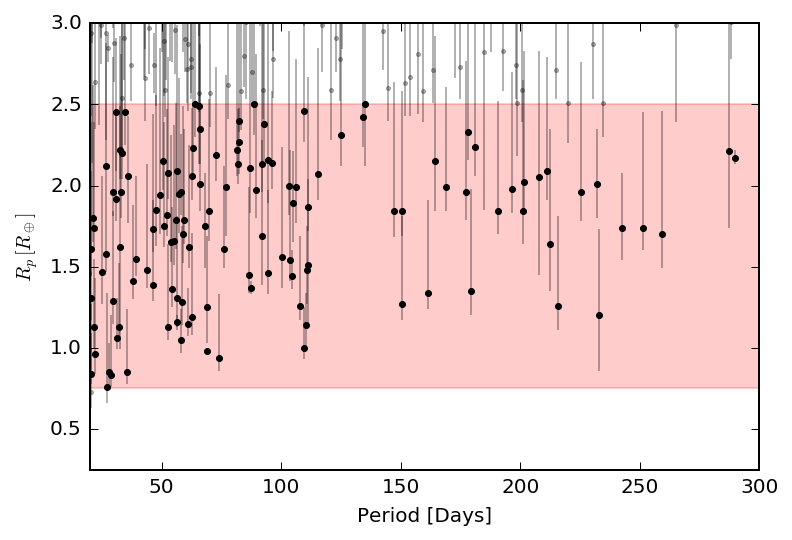

In [9]:
#%%=========================================================
# Plot the measurements with error bars, in insolation-radius parameter space
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T

if(periodInsolationSwitch=="I"):
    pl.xlabel("insolation [Earth units]")
    pl.errorbar(base_kois.koi_insol, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
    pl.plot(kois.koi_insol, kois.koi_prad, ".k", ms=6)
elif(periodInsolationSwitch=="P"):
    pl.xlabel("Period [Days]")
    pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
    pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
pl.fill_between(x_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="r", alpha=0.2)
pl.xlim(x_rng + 0.1 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))


pl.ylabel("$R_p \, [R_\oplus]$");


In [10]:
#%%=========================================================
# Completeness model helper functions (radius and orbital period)

from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

def get_delta(k, catalogSwitch, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    
    if(catalogSwitch == '1'):
        maxDepth = 0.84*delta_max
        # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
        # return 0.84*delta_max
    elif(catalogSwitch == '2'):
        # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1
        #return 1.0* delta_max
        maxDepth = 1.0*delta_max
    
    return maxDepth

# 14 pulse durations
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

def get_mes(star, period, rp, tau, catalogSwitch, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate the RMS CDPP corresponding to the transit duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k, catalogSwitch) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

# Parameters gamma function model of detection efficiency vs. MES curve
if(catalogSwitch == '1'):
    # !!!!! Q1-Q16 (9.1 pipeline): DFM used the parameters below (GK stars)
     pgam = gamma(4.65, loc=0., scale=0.98)
    # But the parameters for FGK are (4.35, 0, 1.05) according to astro-ph 1507.05097 (Christiansen)
    #pgam = gamma(4.35, loc=0., scale=1.05)
    
elif(catalogSwitch == '2'):
    # !!!!! Parameters for 9.2 pipeline Q1-Q17 DR24 are from Jessie Christiansen
    # Note that these parameters do not apply to M stars!
    pgam = gamma(103.0113, loc=0., scale=0.10583)

# mesthres_cols are column names for the 14 pulse durations
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# pulse_durations_obs are the 14 pulse durations
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e, catalogSwitch):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    # mest is the interpolated MES threshold corresponding to the transit duration
    # tau is the pulse duration
    # pulse_durations_obs are the 14 pulse durations
    # np.array(star[mesthres_cols],dtype=float) are the coresponding MES thresholds
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau, catalogSwitch)
    mest = np.interp(tau, pulse_durations_obs,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    
    # Gamma Parameters for detection efficiency vs. MES model
    if(catalogSwitch == "1"):
        # !!!!! For the 9.1 data
        # return pgam.cdf(x)
        gammaParams = pgam.cdf(x)
    elif(catalogSwitch == "2"):
        # !!!!! DFM originally used no multiplier in the equation below;
        # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
        # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
        gammaParams = 0.78442*pgam.cdf(x)
    
    return gammaParams


def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)


In [11]:
#================================================================================================
#%% This cell contains functions and code for calculating completeness in the
#       parameter space of [ insolation , planet radius ] 
    
    
# Compute completeness grid for period vs radius
def get_completeness(star, period, rp, e, catalogSwitch,with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties (each row is for one star)
    :param period:    the period in days 
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e, catalogSwitch)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom
    #print(len(rp))

# Construct grid for planet radius
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)

if(periodInsolationSwitch == "P"):

    # Period grid
    period = np.linspace(x_rng[0], x_rng[1], 57)
    xLinearGrid = period
    x_grid, rp_grid2 = np.meshgrid(period, rp2, indexing="ij")


elif(periodInsolationSwitch == "I"):

    # Construct grid for insolation
    insolation = np.linspace(x_rng[0], x_rng[1], 57)
    xLinearGrid = insolation
    x_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="ij")

# Compute completeness grid for insolation vs radius
def get_completeness_from_insolation(star, insolation_grid, rp_grid2, e, catalogSwitch, with_geom=True):
    
    # compute the periods corresponding to an insolation grid
    insolation = insolation_grid
    period_grid = get_period_from_insolation( star , insolation )
    
    # completeness 
    completeness = get_completeness(star, period_grid, rp_grid2, e, catalogSwitch, with_geom=True)
    
    return completeness
    
# Compute insolation on the period grid, for a given star 
def get_insolation_from_period( star , period ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Semimajor axis of planet in AU
    aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0) 
    
    # Compute insolation
    insolation = (teffStar/teffSun)**4*(rStar/1)**2*(1/aPlanet)**2
    
    return insolation

# Compute period on the insolation grid, for a given star
def get_period_from_insolation( star , insolation ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Get semimajor axis from star properties and insolation, using
    # insolation = ( teffStar / teffSun )**4 * ( rStar / 1)**2 * ( 1 / aPlanet )**2
    aPlanet = ( ( teffStar / teffSun )**4 * ( rStar / 1)**2 / insolation )**(0.5)
    
    # Get orbit period in days from semimajor axis of planet in AU and start properties, using
    # aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    period = 365.25 * ( aPlanet/( mStar**(1.0/3.0) ) )**(3.0/2.0)
    
    return period



In [12]:
#%%==============================================================================================
# Marginalize detection contours over all selected targets
# including the geometric factor. This takes a few minutes.
new_completeness = np.zeros_like(x_grid)
if(periodInsolationSwitch == "P"):
    for _, star in stlr.iterrows():
        new_completeness += get_completeness(star, x_grid, rp_grid2, 0.0, catalogSwitch, with_geom=True)
elif(periodInsolationSwitch == "I"):
    for _, star in stlr.iterrows():
        new_completeness += get_completeness_from_insolation(star, x_grid, rp_grid2, 0.0, catalogSwitch, with_geom=True)



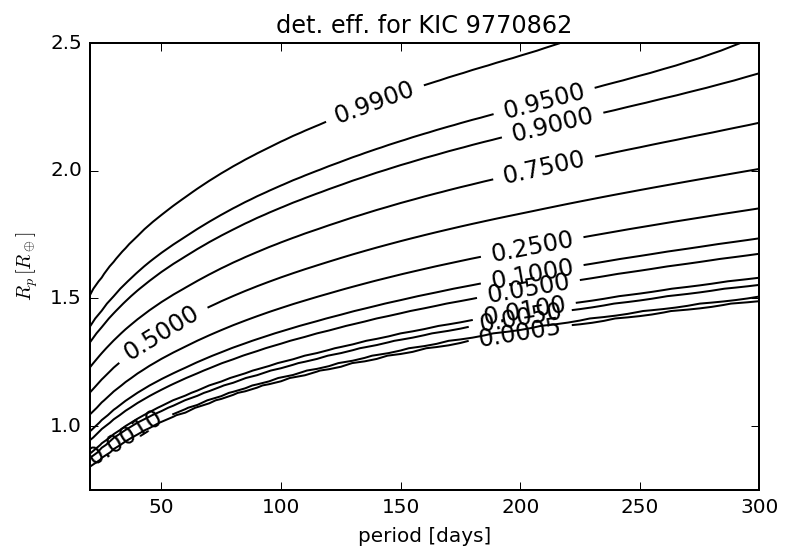

In [13]:
#%%=========================================================
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour (not including geometric effect) for an example target
 
# Repeating for new insolation completeness.  
    
# Choose the first star
star = stlr[stlr.kepid == stlr.kepid.iloc[0]].iloc[0]

# Compute the completeness map on a grid.
X, Y = x_grid, rp_grid2 

if(periodInsolationSwitch == "P"):
    Z = get_completeness(star, X, Y, 0.0, catalogSwitch, with_geom=False)

elif(periodInsolationSwitch == "I"):
    Z = get_completeness_from_insolation(star, X, Y, 0.0, catalogSwitch, with_geom=False)

# Plot with the same contour levels as the figure. Add some contours at low end of completeness.
c = pl.contour(X, Y, Z, [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.4f") 

if(periodInsolationSwitch == "I"):
    pl.xlabel("insolation [Earth units]")
elif(periodInsolationSwitch == "P"):
    pl.xlabel("period [days]")

pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC {0}".format(np.min(stlr.kepid.iloc[0])));


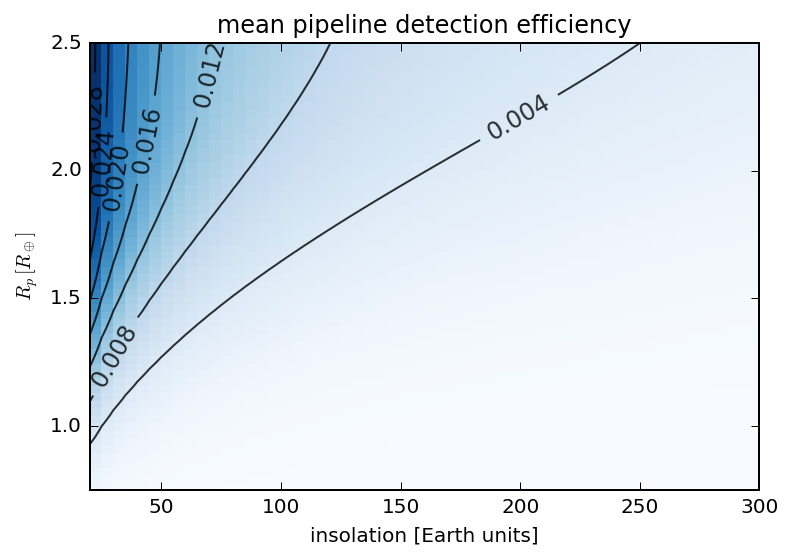

In [14]:
#%%=========================================================
# Plot the average new_completeness contour (radius-insolation)
# Include the geometric effect
pl.pcolor(x_grid, rp_grid2, new_completeness, cmap="Blues")
c = pl.contour(x_grid, rp_grid2, new_completeness / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [15]:
#%%=========================================================
# Population inference with an independent power law model
# Using modified code above that computes 
# completeness in the parameter space of [ insolation , planet radius ], 

# A double power law model for the population.
''' def population_model_insolation(theta, insolation, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(insolation)
    for x, rng, n in zip((insolation, rp),
                         (insolation_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v
'''

# A double power law model for the population.
def population_model(theta, xLinearGrid, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(xLinearGrid)
    for x, rng, n in zip((xLinearGrid, rp),
                         (x_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v


# The ln-likelihood function given at the top of this post.
# change to insolation from planet catalog

# Insolation and radius for planets in catalog
if(periodInsolationSwitch == "P"):
    koi_x = np.array(kois.koi_period)
elif(periodInsolationSwitch == "I"):
    koi_x = np.array(kois.koi_insol)
    
koi_rps = np.array(kois.koi_prad)

# Parameter space volume in each bin of [insolation, radius] grid
# Note the bins are not uniformly spaced in insolation
vol = np.diff(x_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model(theta, x_grid, rp_grid2) * new_completeness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    #print(norm)
    ll = np.sum(np.log(population_model(theta, koi_x, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf
# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15



In [16]:
#%%=========================================================
# Maximum likelihood solution by minimizing negative log-likelihood
from scipy.optimize import minimize
# Initial guess for logF, beta, and alpha
theta_0 = np.array([1, 0.66, -1.5])
#DFM original initial values below
#theta_0 = np.array([np.log(0.75), -0.53218, -1.5])

r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)
# r.x is the vector of parameters (logF, beta, and alpha) from the maximum likelihood solution


      fun: 961.19396376660018
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.29691829e-04,   1.17097443e-03,  -5.68434189e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 11
   status: 0
  success: True
        x: array([ 0.21100836,  0.12443774, -2.44881953])


In [17]:
#%%=========================================================
# Plot the maximum likelihood solution

# We'll reuse these functions to plot all of our results.

# This function plots the density of samples of a double power law,
# as a function of the x0 input, marginalized over the y input
def make_plot(pop_comp, x0, x, y, ax):
    # pop_comp is a two-dimensional array of completeness values
    # pop_comp.shape is 57(insolation) x 61(radius)  
    # x0 is: bin edges of second variable (radius), for model fitting
    # x is rebinning of x0 into a coarser grid for the plots
    # y is: bin edges of first variable (insolation), for model fitting
    # Mid-bin values of the 2D array pop_comp, along the first dimension -- insolation
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    # on first call, pop is 56 x 61

    # Integrate completeness over the first variable, y, insolation
    # np.diff(y)[None, :, None] is the parameter space interval in y
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    # After above command, pop is 1D, collapsed onto the radius dimension
    
    # Credible regions in x: radius
    # x is used only to get the parameter space interval dx in radius for the plot
    # Note: Assumes bin spacing np.diff(x) is uniform
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    # print(c)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    # c is the median value of the distribution over 
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    
    # print(samples.shape)
    # print(len(samples))
    # len(samples) is the length of the MCMC chain
    pop = np.empty((len(samples), x_grid.shape[0], x_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        # insolation_grid and rp_grid2 are meshgrids, 57x61
        # print(p)
        # print(rp_grid2.shape)
        # print(insolation_grid.shape)
        # print(i)
        # power law planet density on insolation, radius grid
        pop[i] = population_model(p, x_grid, rp_grid2)
        # planet density at the point corresponding to earth (insolation = 1 and radius = 1)
        gamma_earth[i] = population_model(p, 1.0, 1.0) * 1.0
        # print(gamma_earth[i])
        
    # Set up 4x4 grid of plots
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Histogram of planet radius over a new grid
    # Using a coarser grid for the plot
    dx = 5*(rp2[1] - rp2[0])
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the predicted radius distribution against the observed radius distribution
    ax = axes[0, 0]
    
    # Predicted radius distribution
    # rp2 is of length 61
    # nsolation is of length 57
    # pop is 57 x 61 -- so it's insolation x radius
    # new_completeness is 1 x 57 x 61
    make_plot(pop * new_completeness[None, :, :], rp2, x, xLinearGrid, ax)
    
    # Observed radius distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp2, x, xLinearGrid, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    # ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Histogram of insolation or period over a new grid.
    # Using a coarser grid for the plot
    dx = 5*(xLinearGrid[1] - xLinearGrid[0])
    
    x = np.arange(x_rng[0], x_rng[1] + dx, dx)
    n, _ = np.histogram(koi_x, x)
    
    # Plot the predicted insolation distribution against the observed insolation distribution
    ax = axes[1, 0]
    
    # Predicted insolation or period distribution
    make_plot(np.swapaxes(pop * new_completeness[None, :, :], 1, 2), xLinearGrid, x, rp2, ax)
    
    # Observed insolation or period distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    # ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlim(0.5, x_rng[1])
    # ax.set_ylim(0, 25)
    ax.set_ylim(0, 40)
    
    if(periodInsolationSwitch=='I'):
        ax.set_xlabel("insolation, [Earth units]")
    elif(periodInsolationSwitch=='P'):
        ax.set_xlabel("period, [Days]")


    ax.set_ylabel("# of detected planets")
    
    # Plot the true insolation distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), xLinearGrid, x, rp2, ax)
    ax.set_xlim(x_rng[0], x_rng[1])
    
    if(periodInsolationSwitch=='I'):
        ax.set_ylabel("$\mathrm{d}N / \mathrm{d}I$; $\Delta I = $")
        ax.set_xlabel("insolation, [Earth units]")

    elif(periodInsolationSwitch=='P'):
        ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = $")
        ax.set_xlabel("period, [Days]")


    return gamma_earth



[ 0.0027657]


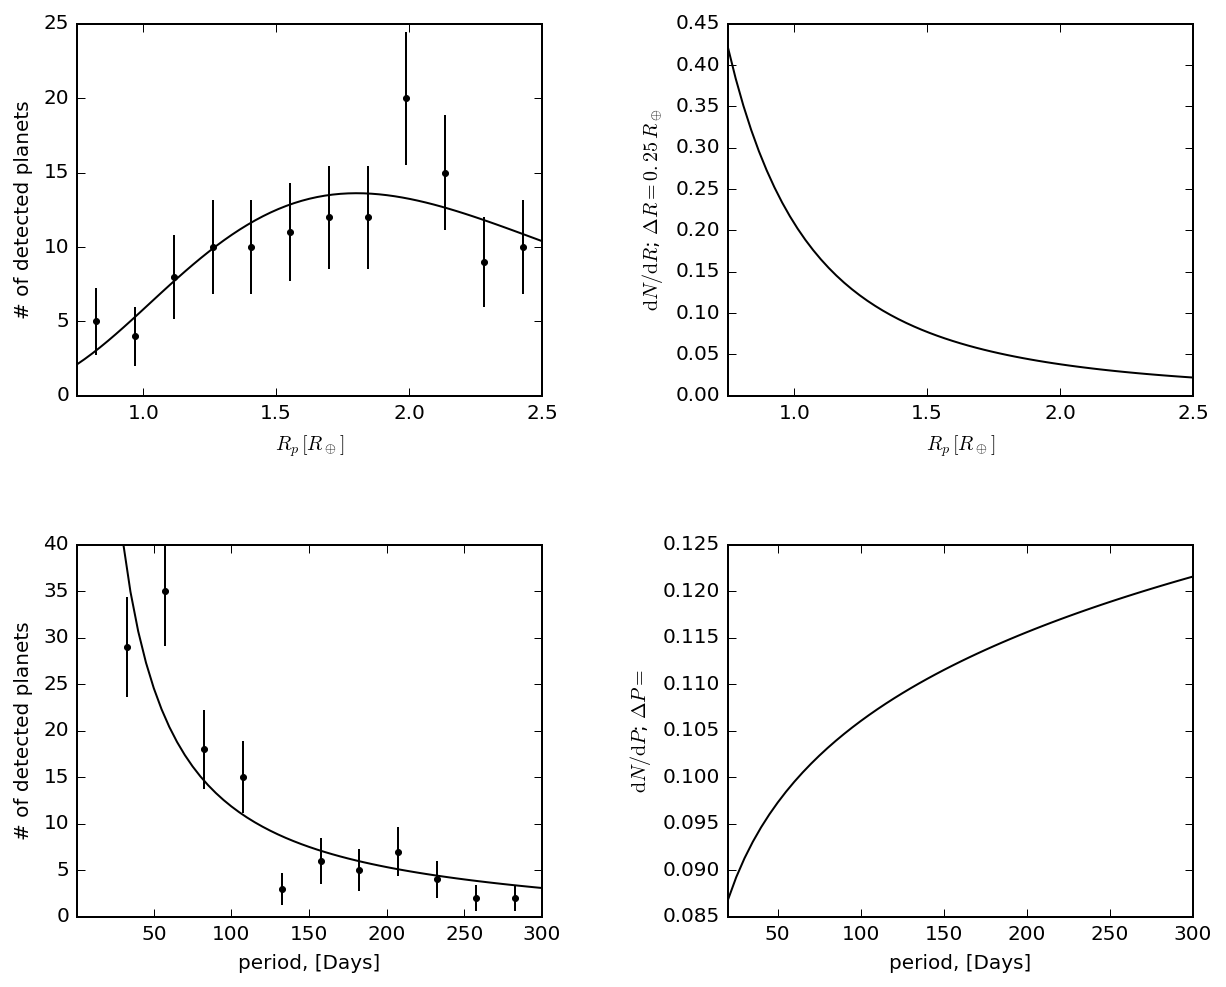

In [18]:
#%%=========================================================

# This line calls the plotting machinery above, and returns the maximum likelihood value of gamma_earth
# Note that r.x is the set of parameters [ lnf0, beta, alpha ] returned by the maximum likelihood fit
print(plot_results(r.x));

# Or, try your own values for the parameters
# thetaTry = np.array([.01, -1.2, -1.1])
# print(plot_results(thetaTry));

In [19]:
#%%=========================================================
# Sample from the posterior probability distribution for the population parameters using emcee
import emcee

ndim, nwalkers = len(r.x), 16

# Initialize, and set trial vector as Max Likelihood solution perturbed by a small random vector
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# specify number of samples and number of burn-in samples
nSamplesPerChain = 4000
nBurnIn = nSamplesPerChain/4
nChains = nwalkers

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnIn)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, nSamplesPerChain)



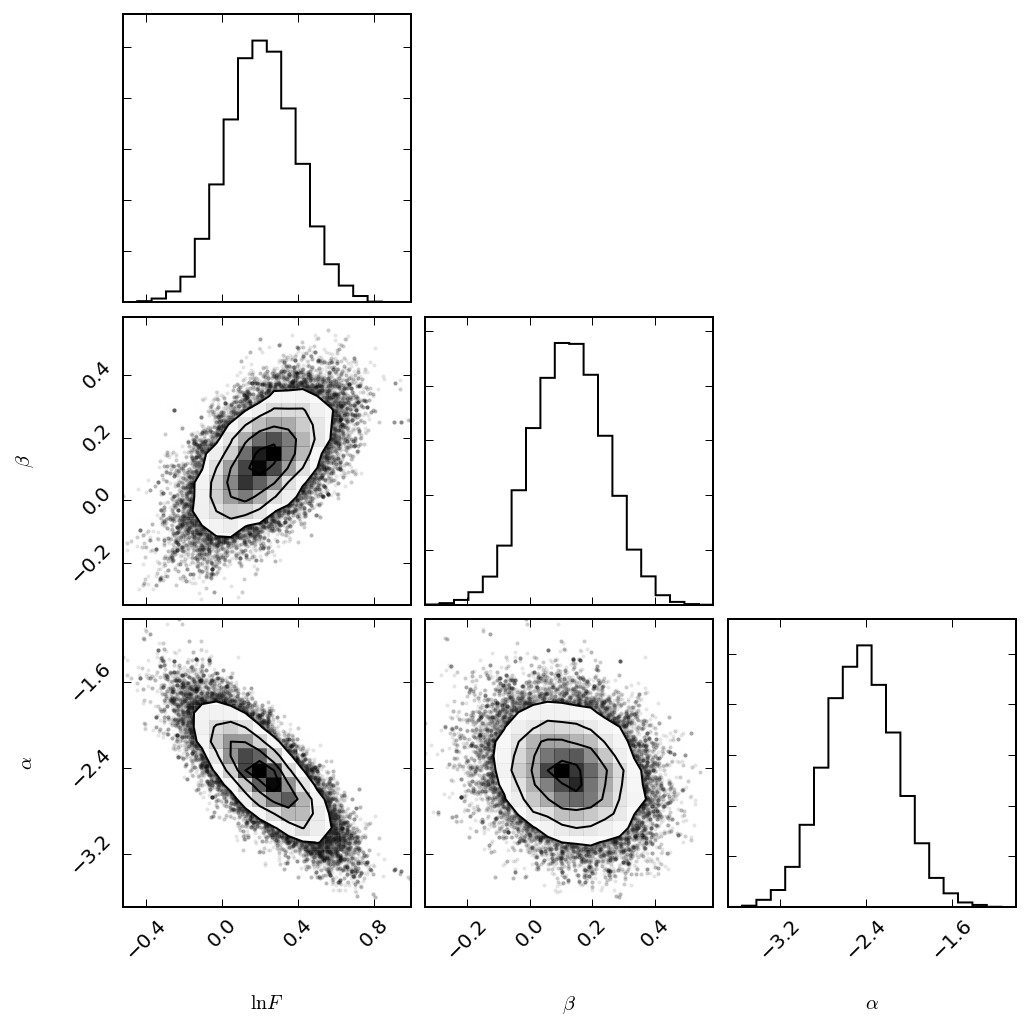

In [20]:
#%%=========================================================
# Triangle plot of PDFs using DFMs corner package
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);


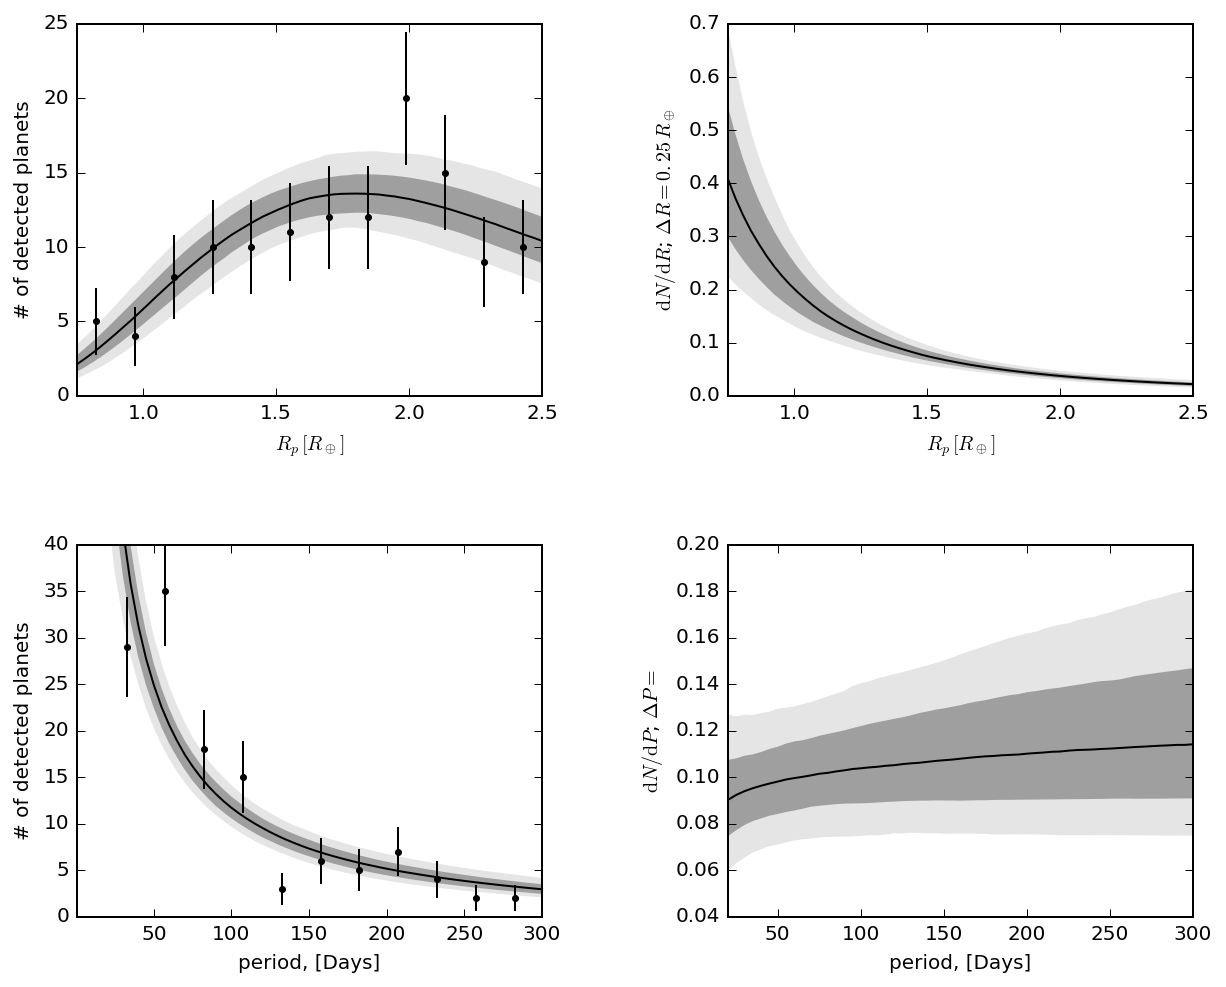

In [21]:
#%%=========================================================
# Plot marginalized posteriors of N and dN/dR
# For Rp, marginalize over P
# For P, marginalize over Rp
# For N, plot also the data and the error bars

# Problem -- plotting all the chains maxes out my PCs memory.    
# Solution -- plot only the last 4000 chains 
gamma_earth = plot_results(sampler.flatchain[60000:63999,:])


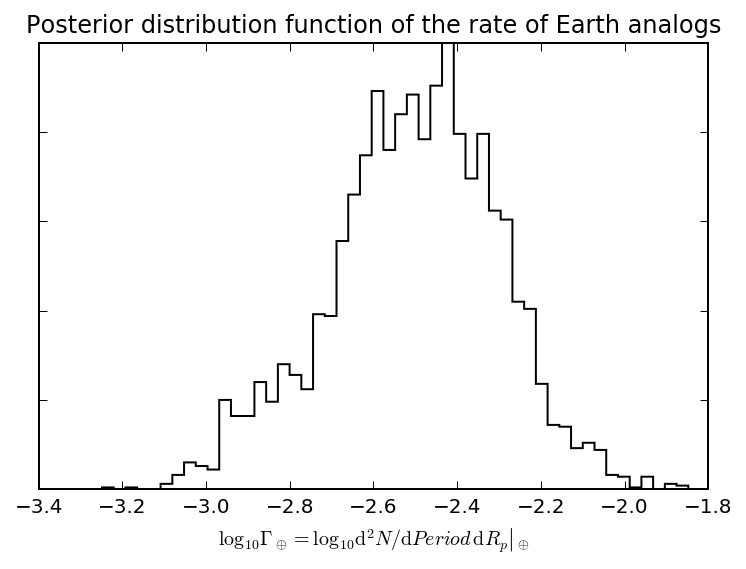

In [22]:
#%%=========================================================
# Posterior distribution of log10 gamma_earth
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Posterior distribution function of the rate of Earth analogs")
# pl.xlabel(r"$\log_{10}\Gamma_\oplus $");

if(periodInsolationSwitch == 'I'):
    pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Insolation \, \mathrm{d} R_p \right |_\oplus$");
elif(periodInsolationSwitch == 'P'):
    pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}^2 N / \mathrm{d} Period \, \mathrm{d} R_p \right |_\oplus$");



16, 50, 84 percentile range for integrated gamma = [ 0.21358794  0.26643871  0.32955689] 


(0, 1)

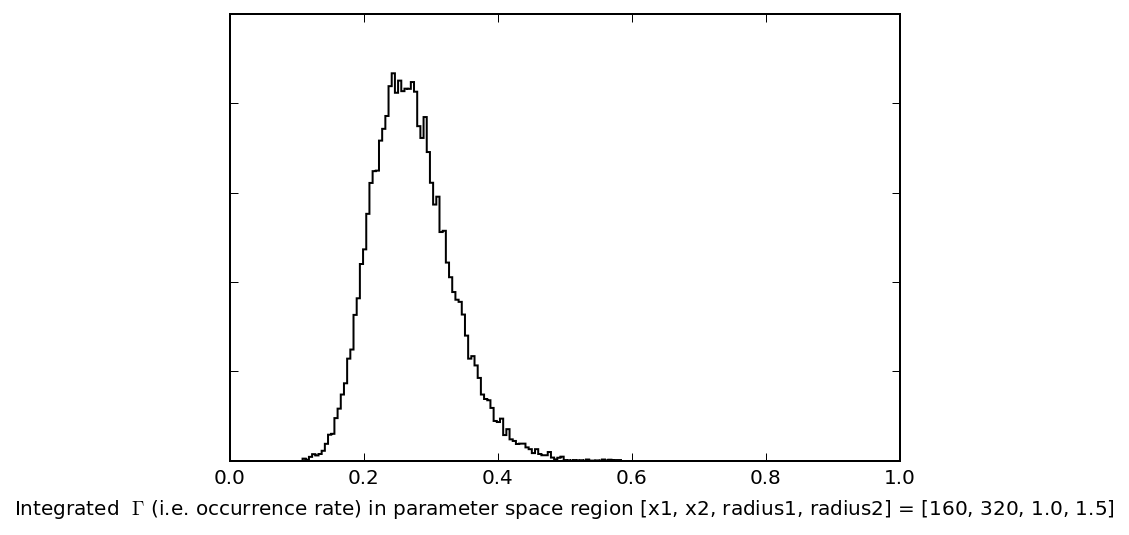

In [23]:

#%%=========================================================
# Integrate the planet density over a given range in insolation and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region

def integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch):
    
    # Break out parameters 
    lnf0, beta, alpha = theta
    
    # Phase space boundaries for our model
    if(periodInsolationSwitch == 'P'):
        x_rng = (20, 300)
    elif(periodInsolationSwitch == 'I'):
        x_rng = (0.2, 20)
            
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ x , radius] parameter space
    integral_over_x = (x2**(beta + 1) - x1**(beta + 1))/(x_rng[1]**(beta + 1) - x_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_x*integral_over_radius*np.exp(lnf0)
    
    return eta
    

#%%=========================================================
#  Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius parameter space
#   NOTE: using SAG-13 binning scheme

# Initialize   
int_gamma_samples = np.empty(len(sampler.flatchain))


# !!!!! Choose period or insolation bin edges (according to stellar type), for occurrence rate calculation
if(periodInsolationSwitch == 'I'):

    if(stellarTypeSwitch == 'A'):
        # Select A dwarfs
        # !!!!! Using same range as for G dwarfs, for now
        x1 = 0.295
        x2 = 1.824
        
    elif(stellarTypeSwitch == 'F'):
        # Select F dwarfs
        # !!!!! Using same range as for G dwarfs, for now
        x1 = 0.295
        x2 = 1.824

    elif(stellarTypeSwitch == 'G'):
        # Select G dwarfs
        x1 = 0.295
        x2 = 1.824
       
    elif(stellarTypeSwitch == 'K'):
        # Select K dwarfs
        x1 = 0.235
        x2 = 1.681

    elif(stellarTypeSwitch == 'M'):
        # Select M dwarfs
        x1 = 0.205
        x2 = 1.514

elif(periodInsolationSwitch == 'P'):
    
    x1 = 160
    x2 = 320

# !!!!! Choose radius bin edges for occurrence rate calculation
radius1 = 1.0
radius2 = 1.5

# Integrate the gamma posterior distribution over the selected phase space bin
# NOTE -- This gives the exoplanet occurrence rate in that phase space bin!
for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,x1,x2,radius1,radius2,periodInsolationSwitch)

# print occurrence rate for this parameter space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 100, histtype="step", color="k")
pl.gca().set_yticklabels([])
if(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and insolation")
elif(periodInsolationSwitch == 'I'):
    pl.title("Integrated ocurrence rate over radius and period")
    
pl.xlabel(r"Integrated  $\Gamma$ (i.e. occurrence rate) in parameter space region [x1, x2, radius1, radius2] = {0}".format([x1,x2,radius1,radius2]));    
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks
pl.gca().set_xlim([0,1])


                                                




In [24]:
#=====================================================================
# Gather and save occurrence rate data for emcee sampler
# Could make this a function which takes as inputs
# the posterior samples array 
# the names of the files to save to
# nSamplesPerChain
# nChains
samples = sampler.flatchain

# Define radius and period bin edges
radiusBinEdges = [0.67, 1.0, 1.5, 2.3, 3.4, 5.1, 7.6, 11, 17]
periodBinEdges = [10, 20, 40, 80, 160, 320, 640]

# Initialize dictionary
# occurrenceRateData = dict()

# Initialize lists for median, lower and upper occ rate limits
listMedian = [None]*(len(radiusBinEdges)-1)
listLowerCredibleInterval = [None]*(len(radiusBinEdges)-1)
listUpperCredibleInterval = [None]*(len(radiusBinEdges)-1)

# Loop over desired period and radius bins and compute occurrence rates
for iRadius in range(len(radiusBinEdges)-1):
    # Initialize lists for rows
    listMedianRow = []
    listLowerCredibleIntervalRow = []
    listUpperCredibleIntervalRow = []
    for iPeriod in range(len(periodBinEdges)-1):
        # Integrate the gamma posterior distribution over the selected phase space bin
        # NOTE -- This gives the exoplanet occurrence rate in that phase space bin
        int_gamma_samples = [None]*(len(samples))
        for i, theta in enumerate(samples):
            int_gamma_samples[i] = integrated_gamma(theta,periodBinEdges[iPeriod],periodBinEdges[iPeriod+1],
                                                   radiusBinEdges[iRadius],radiusBinEdges[iRadius+1],periodInsolationSwitch)

        # Print result for this bin
        print("\nRadius Bin "+str(radiusBinEdges[iRadius])+" to "+str(radiusBinEdges[iRadius+1])+" , Period Bin "+str(periodBinEdges[iPeriod])+" to "+str(periodBinEdges[iPeriod+1]))
        print("     Occurrence rate 16, 50, 84 percentile range : {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

        # Populate the dictionary with the result for this bin
        # binKey = "bin_" + str(radiusBinEdges[iRadius]) + "_" + str(periodBinEdges[iPeriod])
        # occurrenceRateData[binKey] = np.percentile(int_gamma_samples,[16,50,84])
        
        # Accumulate a row vector of median occurrence rates and their upper and lower credible intervals
        # for period bins at this radius
        listMedianRow.append(np.percentile(int_gamma_samples,[50]))
        listLowerCredibleIntervalRow.append(np.percentile(int_gamma_samples,[16]))
        listUpperCredibleIntervalRow.append(np.percentile(int_gamma_samples,[84]))
              
    # Append the row vector of results into the arrays for the median and lower and upper occ rate limits
    listMedian[iRadius] = listMedianRow
    listLowerCredibleInterval[iRadius] = listLowerCredibleIntervalRow
    listUpperCredibleInterval[iRadius] = listUpperCredibleIntervalRow
        
# Save the dictionary
#with open('occurrence_rate_data_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
#    pickle.dump(occurrenceRateData, handle)
    
# Save the .csv files
np.savetxt('eta_emcee_occurrence_rate_median_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listMedian), delimiter=",",fmt='%.5f')
np.savetxt('sigma_n_emcee_occurrence_rate_lower_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listLowerCredibleInterval), delimiter=",",fmt='%.5f')
np.savetxt('sigma_p_emcee_occurrence_rate_upper_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listUpperCredibleInterval), delimiter=",",fmt='%.5f')




Radius Bin 0.67 to 1.0 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.01550348  0.02095855  0.02781607] 

Radius Bin 0.67 to 1.0 , Period Bin 20 to 40
     Occurrence rate 16, 50, 84 percentile range : [ 0.03473734  0.04558923  0.05908539] 

Radius Bin 0.67 to 1.0 , Period Bin 40 to 80
     Occurrence rate 16, 50, 84 percentile range : [ 0.07598597  0.09897902  0.12828978] 

Radius Bin 0.67 to 1.0 , Period Bin 80 to 160
     Occurrence rate 16, 50, 84 percentile range : [ 0.16250097  0.216069    0.28549625] 

Radius Bin 0.67 to 1.0 , Period Bin 160 to 320
     Occurrence rate 16, 50, 84 percentile range : [ 0.33972962  0.47015184  0.64717266] 

Radius Bin 0.67 to 1.0 , Period Bin 320 to 640
     Occurrence rate 16, 50, 84 percentile range : [ 0.70123512  1.02683608  1.48861716] 

Radius Bin 1.0 to 1.5 , Period Bin 10 to 20
     Occurrence rate 16, 50, 84 percentile range : [ 0.00944792  0.01183295  0.01463181] 

Radius Bin 1.0 to 1.5 , Period Bin 20 to 40

In [25]:
import pystan
import corner
import numpy as np
import gc
np.set_printoptions(threshold='nan')
import matplotlib as plt

#%%===============================================================================================
# Pre-compute some values to be used in the Stan model

# change to column major for PyStan version (overwrite old version here)

if(periodInsolationSwitch == "P"):
    # Period grid
    x_grid, rp_grid2 = np.meshgrid(period, rp2, indexing="xy")

elif(periodInsolationSwitch == "I"):
    # Construct grid for insolation
    x_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="xy")

# Column names for RMS CDPP
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]

# Values of RMS CDPP corresponding the the 14 pulse durations for all selected stars (column)
# cdpp_obs = np.array(star[cdpp_cols], dtype=float) # <- for one row (one star) change star for stlr.
cdpp_obs_all = np.array(stlr[cdpp_cols], dtype=float)

# Values for the 14 pulse durations derived from the column names
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],dtype=float)
nPulses = len(pulse_durations_obs)

# Column names for the 14 MES thresholds
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# MES threshold values corresponding to the 14 pulse durations
mesthres_obs_all = np.array(stlr[mesthres_cols],dtype=float)
#print(mesthres_obs_all)                        
# mest <- np.interp(tau, pulse_durations_obs, mesthres_obs, dtype=float)
# x <- mes - 4.1 - (mest - 7.1);

if(periodInsolationSwitch == "P"):
    # Period grid
    x_rng = (20, 300)
    x_grid = np.linspace(x_rng[0], x_rng[1], 57)
    nxGrid = len(x_grid)

elif(periodInsolationSwitch == "I"):
    # Insolation grid
    x_rng = (0.2, 20)
    x_grid = np.linspace(x_rng[0], x_rng[1], 57)
    nxGrid = len(x_grid)

# Planet radius grid
planet_radius_rng = (0.75, 2.5s)
planet_radius_grid = np.linspace(planet_radius_rng[0], planet_radius_rng[1], 61)
nRadiusGrid = len(planet_radius_grid)

# Make 2D meshgrids for bin edges.
planet_radius_grid_vol, x_grid_vol = np.meshgrid(planet_radius_grid, x_grid, indexing="xy")

# 2D grid of insolation-radius parameter space bin volumes at bin centers
vol = np.diff(x_grid_vol, axis=0)[:, :-1] * np.diff(planet_radius_grid_vol, axis=1)[:-1, :]
volShape = list(vol.shape)

# Stellar parameters (for all stars in the stellar catalog)
teffStar = stlr.teff
teffSun = 5777
rStar = stlr.radius
mStar = stlr.mass

# number of stars in the stellar catalog:
nStar = len(stlr)

# Insolation and radius for planets in the planet catalog
if(periodInsolationSwitch == "P"):
    koi_x = np.array(kois.koi_period)
elif(periodInsolationSwitch == "I"):
    koi_x = np.array(kois.koi_insol)

# Catalog radii of observed planets
koi_rps = np.array(kois.koi_prad)

# Catalog radius errors of observed planets
# Replace zeros of koi_rps_err1 with the minimum nonzero value of koi_rps_err1
koi_rps_err1 = np.array(kois.koi_prad_err1)
ind1Zero = np.where(koi_rps_err1 == 0)[0]
ind1NonZero = np.where(koi_rps_err1 != 0)[0]
koi_rps_err1[ind1Zero] = np.min(koi_rps_err1[ind1NonZero])

# Replace zeros of koi_rps_err2 with the negative minimum nonzero abs value of koi_rps_err2
koi_rps_err2 = np.array(kois.koi_prad_err2)
ind2Zero = np.where(koi_rps_err2 == 0)[0]
ind2NonZero = np.where(koi_rps_err2 != 0)[0]
koi_rps_err2[ind2Zero] = -np.min(np.abs(koi_rps_err2[ind1NonZero]))

# Number of planets selected from the KOI catalog
nKois = len(kois)

# Eccentricity is set to zero for now.
e = 0.0

# Dataspan is length of time between first and last observations of each star
star_dataspan = stlr.dataspan

# Dutycycle is the fraction of cadences with valid observations
star_dutycycle = stlr.dutycycle

# Upper and lower limits for uniform distribution
koi_rps_obs_lower = koi_rps + koi_rps_err2
koi_rps_obs_upper = koi_rps + koi_rps_err1

# Garbage collection
gc.isenabled()
gc.collect()



249

In [26]:
# Check that everything is there
print(new_completeness.shape)
print(cdpp_cols)
print(len(cdpp_obs_all))
print(len(pulse_durations_obs))
print(mesthres_cols)
print(len(mesthres_obs_all))
print(nRadiusGrid)
print(nxGrid)
#print(nPeriodGrid)
#print(nInsolationGrid)
print(planet_radius_grid_vol.shape)
print(x_grid_vol.shape)
print(vol.shape)
print(nStar)
print(len(koi_x))
#print(len(koi_insolation))
print(len(koi_rps))
print(len(koi_rps_err1))
print(len(koi_rps_err2))
print(nKois)
print(planet_radius_rng)
#print(insolation_rng)
print(x_rng)
print(x_grid.shape)
#print(insolation_grid.shape)
print(koi_rps_obs_lower)

(57, 61)
['rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p0']
59792
14
['mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0']
59792
61
57
(57, 61)
(57, 61)
(56, 60)
59792
126
126
126
126
126
(0.75, 3.4)
(20, 300)
(57,)
[ 1.96  1.97  1.59  1.49  1.61  1.34  1.54  2.15  2.06  1.69  1.8   1.65
  1.92  2.24  1.64  2.31  1.27  1.93  0.96  1.83  2.25  2.06  2.13  0.78
  2.06  1.91  1.69  1.69  1.61  1.66  1.03  1.84  1.86  1.71  1.78  1.77
  1.27  1.68  1.77  1.36  1.29  1.89  2.04  1.64  2.33  1.01  1.33  2.3
  2.27  1.82  1.47  1.25  2.13  1.62  1.8   0.97  1.98  2.07  1.08  1.05
  2.03  1.49  1.11  2.01  2.12  1.84  1.78  2.12  2.16  1.51  1.05  1.83
  

In [28]:

from pystan import StanModel

stan_model_occ = """

functions {

real[,] population_model_insolation(int nxGrid, int nRadiusGrid, 
real lnf0, real alpha, real beta, real[] x_grid, real[] planet_radius_grid, 
real[] planet_radius_rng, real[] x_rng) {

/* Population inference with an independent power law model
   Using modified code above that computes 
   completeness in the parameter space of [ insolation , planet radius ], 

   A double power law model for the population.

   :param nxGrid: size of insolation grid
   :param nRadiusGrid: size of radius grid
   :param lnf0: normalization, 
   :param beta: exponent of insolation power law,
   :param alpha: exponent of radius power law
   :param x_grid:       //1D grid
   :param planet_radius_grid:    //1D grid
   :param x_rng: // lower and upper boundary values of insolation grid
   :param radius_rng:     // lower and upper boundary values of radius grid
   
*/    

// Declare internal variables
   real powerLawNumberDensity[nRadiusGrid,nxGrid];

// Loop over phase space bins, compute number density in each bin, 
//      from the power law using the input lnf0, alpha and beta parameters

    for (j in 1:nxGrid) 
       for (i in 1:nRadiusGrid) {

       powerLawNumberDensity[i,j] <- ( exp( lnf0 ) * ( alpha+1 ) * ( beta+1 ) * ( planet_radius_grid[i]^alpha ) * ( x_grid[j]^beta ) ) / ( ( planet_radius_rng[2]^( alpha+1 ) - ( planet_radius_rng[1]^( alpha+1 ) ) ) * ( ( x_rng[2]^( beta+1 ) ) - ( x_rng[1]^( beta+1 ) ) ) );
     }
   return powerLawNumberDensity;
}

real lnlike(real alpha, real beta, real lnf0, int nKois, real[] planet_radius_rng, 
real[] x_rng, real[,] vol, real[] x_grid, real[] planet_radius_grid, 
real[] koi_x, real[] koi_rps_true, int nRadiusGrid, int nxGrid, real e, real[,] new_completeness ) {

/* log likelihood function

    :param alpha:
    :param beta:
    :param lnf0:
    :param nKois
    :param planet_radius_rng
    :param x_rng
    :param vol:
    :param x_grid:
    :param planet_radius_grid:
    :param koi_x:
    :param koi_rps_true:
    :param nRadiusGrid
    :param nxGrid
    :param e
    :param new_completeness
        
*/

// Declare internal variables

    real pop[nRadiusGrid,nxGrid];
    real pop1[nRadiusGrid,nxGrid];
    real pop2[nRadiusGrid,nxGrid];
    real populationDensity[nRadiusGrid-1,nxGrid-1];
    real sumExpectedCounts;
    real logPop[nKois];
    real lnLikelihood;
    real sumLogPop;
    real lnLikelihood0;
    real popModelInsol0[nRadiusGrid,nxGrid];
    real popModelInsol[nKois,nKois];
    
     
    // Compute the population model for a grid over [ insolation, radius ] parameter space
    popModelInsol0 <- population_model_insolation(nxGrid, nRadiusGrid, lnf0, alpha, beta, x_grid, planet_radius_grid, planet_radius_rng, x_rng);

    // Compute the expected density of detections per bin in the [ insolation, radius ] parameter space,
    // based on the population model and the completeness
        for (i in 1:nRadiusGrid)
            for (j in 1: nxGrid) {

            //sum_completeness_0[i,j] <- new_completeness[j,i];
             pop[i,j] <- popModelInsol0[i,j] * new_completeness[j,i];

        }
        
    // Initialize
    sumExpectedCounts <- 0.0; 
    sumLogPop <-0.0;
    
    for (i in 1:nRadiusGrid-1)
      for (j in 1: nxGrid-1) {

      
         // Compute the number density of detections on a grid of bin centers
         
         // Figured out the proper syntax for translation of the Python line below into Stan
         // pop <- 0.5*(pop[:-1, :-1] + pop[1:, 1:]) is python syntax from DFM notebook.
         // Note that indices start with 1 in Stan
         pop1[i,j] <- pop[i,j];
         pop2[i,j] <- pop[i+1,j+1];
         populationDensity[i,j] <- 0.5*(pop1[i,j]+pop2[i,j]);
         
         // Integrate the planet counts over the phase space volume
         sumExpectedCounts <- sumExpectedCounts + (populationDensity[i,j]*vol[j,i]);
      }
   
   // Population model evaluated over the list of detected planets
   // 
   popModelInsol <- population_model_insolation(nKois, nKois, lnf0, alpha, beta, koi_x, koi_rps_true, planet_radius_rng, x_rng);

    for (k in 1:nKois) {
        logPop[k] <- log( popModelInsol[k,k] );
        sumLogPop <- sumLogPop + logPop[k];
    }
    
    // Combine the two terms to form the log-likelihood function for the Inhomogeneous Poisson Process 
    lnLikelihood <- sumLogPop - sumExpectedCounts;
    
    // Catch error: if lnLikelihood has bad value, return a very small number
    lnLikelihood0 <- if_else( is_inf(lnLikelihood) || is_nan(lnLikelihood) , -1e15, lnLikelihood );
    
   return lnLikelihood0;
   
} 

}
// end function block


data {

// Declare precomputed variables as data

int<lower=1> nKois;

int<lower=1> nRadiusGrid;

int<lower=1> nxGrid;

real x_rng[2]; 

real planet_radius_rng[2];

real x_grid[nxGrid];

real planet_radius_grid[nRadiusGrid];

real vol[nxGrid-1,nRadiusGrid-1];

real koi_x[nKois];

real koi_rps_obs[nKois];

real koi_rps_err1[nKois];

real koi_rps_err2[nKois];

real koi_rps_obs_lower[nKois];

real koi_rps_obs_upper[nKois];

real e;

real new_completeness[nxGrid,nRadiusGrid];


}


parameters {

// For v1: only compute population level parameter posteriors.
real<lower=-5,upper=5> alpha; 
real<lower=-5,upper=5> beta;
real<lower=-5,upper=5> lnf0;

# Ad hoc lower bound constraint on planet radius
real<lower=0.5> koi_rps_true[nKois];


}

model {

    // Hyperpriors
    alpha ~ uniform(-5,5);
    beta ~ uniform(-5,5);
    lnf0 ~ uniform(-5,5);

    for (n in 1:nKois)
        koi_rps_true[n] ~ normal(koi_rps_obs[n], koi_rps_err2[n]);
        // koi_rps_true[n] ~ normal(koi_rps_obs[n], koi_rps_err1[n]);
        //koi_rps_true[n] ~ uniform(koi_rps_obs_lower[n],koi_rps_obs_upper[n]);
   
    // Sample using lnLikelihood function
    increment_log_prob(lnlike(alpha, beta, lnf0, nKois, planet_radius_rng, x_rng, vol, x_grid, planet_radius_grid, koi_x, koi_rps_true, nRadiusGrid, nxGrid, e, new_completeness));
}


"""

# Compiled Stan Model
sm = StanModel(model_code=stan_model_occ)






In [ ]:


'''data = {'new_completeness':new_completeness, 'star_dutycycle':star_dutycycle, 'star_dataspan':star_dataspan, 
        'nStar':nStar, 'nKois':nKois,'nPulses':nPulses,'nRadiusGrid':nRadiusGrid, 'nxGrid':nxGrid, 
        'cdpp_obs_all':cdpp_obs_all, 'mesthres_obs_all':mesthres_obs_all, 'pulse_durations_obs':pulse_durations_obs, 
        'x_rng':x_rng, 'planet_radius_rng':planet_radius_rng,
        'x_grid':x_grid, 'planet_radius_grid':planet_radius_grid, 
        'vol':vol, 'teffStar':teffStar,'teffSun':teffSun, 'rStar':rStar, 'mStar':mStar,
        'koi_x':koi_x, 'koi_rps':koi_rps, 'e':e}
'''
data = {'new_completeness':new_completeness, 'nKois':nKois,'nRadiusGrid':nRadiusGrid, 'nxGrid':nxGrid, 
        'x_rng':x_rng, 'planet_radius_rng':planet_radius_rng,'x_grid':x_grid, 
        'planet_radius_grid':planet_radius_grid, 
        'vol':vol,'koi_x':koi_x, 'koi_rps_obs':koi_rps, 'koi_rps_err1':koi_rps_err1, 'koi_rps_err2':abs(koi_rps_err2),'e':e,
        'koi_rps_obs_lower':koi_rps_obs_lower,'koi_rps_obs_upper':koi_rps_obs_upper}

# Could set initial value to Max Likelihood solution without radius errors
#init = [{'lnf0':0.66,'alpha':-1.82,'beta':-0.65}]
init = [{'lnf0':-0.1,'alpha':-2.2,'beta':-0.5}]

# Set total number of samples per chain and number of chains
# number of production samples is half of the total number of samples;
# the other half are warmup samples.
nTotalPerChain = 1000
nSamplesPerChain = int(round(nTotalPerChain/2))
nChains = 5
fit = sm.sampling(data=data, iter=nTotalPerChain, chains=nChains, n_jobs=-1)
#fit = sm.sampling(data=data, iter=2000, chains=5, init=init, n_jobs=-1)
#fit = pystan.stan(model_code=stan_model_occ, data=data, iter=100, chains=2, n_jobs=-1, verbose=True);

#get_inits(fit)

# Return a dictionary of arrays of posterior samples
la = fit.extract(permuted=True)  
alpha = la['alpha']
beta = la['beta']
lnf0 = la['lnf0']

a = fit.extract(permuted=False)
print(fit)






In [ ]:
# Pack the posterior samples into a numpy array with the same structure as sampler.flatchain
posteriorSamples = np.asarray( np.hstack(( lnf0.reshape(-1,1)  , beta.reshape(-1,1) , alpha.reshape(-1,1)) ) )



In [ ]:
import corner
import scipy as spy

# Make corner plots
corner.corner(np.hstack((lnf0.reshape(-1,1), beta.reshape(-1,1), alpha.reshape(-1,1))), labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);

# Examine results
[np.median(alpha), np.median(beta), np.median(lnf0)]
alphaMode = spy.stats.mode(alpha)
betaMode = spy.stats.mode(beta)
lnf0Mode = spy.stats.mode(lnf0)
print(alphaMode)
print(betaMode)
print(lnf0Mode)
print([np.median(alpha), np.median(beta), np.median(lnf0)])

In [ ]:
# Plot posterior distributions and trends for parameter samples
fit.plot()

In [ ]:
# Archive or retrieve data with pickle
import pickle

# Stan data to be archived
extract = fit.extract()

# Pickle the data
with open('pystan_results_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
    pickle.dump(extract,handle)
    
# Retrieve pickled data
# with open('pystan_results.pkl', 'rb') as handle:
#      retrieved_results = pickle.load(handle)
#


In [ ]:
#=====================================================================
# Gather and save occurrence rate data for Stan sampler
# Could make this a function which takes as inputs
# the posterior samples array 
# the names of the files to save to
# nSamplesPerChain
# nChains
samples = posteriorSamples

# Define radius and period bin edges
radiusBinEdges = [0.67, 1.0, 1.5, 2.3, 3.4, 5.1, 7.6, 11, 17]
periodBinEdges = [10, 20, 40, 80, 160, 320, 640]

# Initialize dictionary
# occurrenceRateData = dict()

# Initialize lists for median, lower and upper occ rate limits
listMedian = [None]*(len(radiusBinEdges)-1)
listLowerCredibleInterval = [None]*(len(radiusBinEdges)-1)
listUpperCredibleInterval = [None]*(len(radiusBinEdges)-1)

# Loop over desired period and radius bins and compute occurrence rates
for iRadius in range(len(radiusBinEdges)-1):
    # Initialize lists for rows
    listMedianRow = []
    listLowerCredibleIntervalRow = []
    listUpperCredibleIntervalRow = []
    for iPeriod in range(len(periodBinEdges)-1):
        # Integrate the gamma posterior distribution over the selected phase space bin
        # NOTE -- This gives the exoplanet occurrence rate in that phase space bin
        int_gamma_samples = [None]*(len(samples))
        for i, theta in enumerate(samples):
            int_gamma_samples[i] = integrated_gamma(theta,periodBinEdges[iPeriod],periodBinEdges[iPeriod+1],
                                                   radiusBinEdges[iRadius],radiusBinEdges[iRadius+1],periodInsolationSwitch)

        # Print result for this bin
        print("\nRadius Bin "+str(radiusBinEdges[iRadius])+" to "+str(radiusBinEdges[iRadius+1])+" , Period Bin "+str(periodBinEdges[iPeriod])+" to "+str(periodBinEdges[iPeriod+1]))
        print("     Occurrence rate 16, 50, 84 percentile range : {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

        # Populate the dictionary with the result for this bin
        # binKey = "bin_" + str(radiusBinEdges[iRadius]) + "_" + str(periodBinEdges[iPeriod])
        # occurrenceRateData[binKey] = np.percentile(int_gamma_samples,[16,50,84])
        
        # Accumulate a row vector of median occurrence rates and their upper and lower credible intervals
        # for period bins at this radius
        listMedianRow.append(np.percentile(int_gamma_samples,[50]))
        listLowerCredibleIntervalRow.append(np.percentile(int_gamma_samples,[16]))
        listUpperCredibleIntervalRow.append(np.percentile(int_gamma_samples,[84]))
              
    # Append the row vector of results into the arrays for the median and lower and upper occ rate limits
    listMedian[iRadius] = listMedianRow
    listLowerCredibleInterval[iRadius] = listLowerCredibleIntervalRow
    listUpperCredibleInterval[iRadius] = listUpperCredibleIntervalRow
    
        
# Save the results in a dictionary
# with open('stan_occurrence_rate_data_'+stellarTypeSwitch+'_'+catalogSwitch+'.pkl', 'wb') as handle:
#    pickle.dump(occurrenceRateData, handle)
    
# Save the .csv files
np.savetxt('eta_stan_occurrence_rate_median_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listMedian), delimiter=",",fmt='%.5f')
np.savetxt('sigma_n_stan_occurrence_rate_lower_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listLowerCredibleInterval), delimiter=",",fmt='%.5f')
np.savetxt('sigma_p_stan_occurrence_rate_upper_credible_interval_'+str(nSamplesPerChain)+'_samples_per_chain_'+str(nChains)+'_chains_'+stellarTypeSwitch+'_'+catalogSwitch+'.csv', np.array(listUpperCredibleInterval), delimiter=",",fmt='%.5f')
